<h2>The Great Resignation, A Classification Problem</h2>

With all of the talk of the Great Resignation in the news these days due to COVID-19 and general job dissatisfaction, I decided to examine whether a person quits their job or not. (For more details see the [reference articles](#reference))

<img src="images/i-quit.jpeg" alt="I Quit!" style="width: 600px;"/>

Not having enough time to conduct my own study for data gathering (<i>we only have 2 weeks for the project</i>), I decided to use some already available data made possible by <a href="https://github.com/VincentTatan/PythonAnalytics/blob/master/Youtube/dataset/HR_comma_sep.csv">Vincent Tatan</a> (<i>thank you!</i>).  

<h3>Data</h3>
The data set can be found at <a href="https://github.com/VincentTatan/PythonAnalytics/blob/master/Youtube/dataset/HR_comma_sep.csv">https://github.com/VincentTatan/PythonAnalytics/blob/master/Youtube/dataset/HR_comma_sep.csv</a>

Fields include:
* employee satisfaction level
* last evaluation
* number of projects
* average montly hours
* time spent at the company 
* if there was a work accident
* was there promotion within the last 5 years
* job category
* salary (grouped by low, medium, or high)   
* whether or not the person quit their job

<h3>Models</h3>
Given the binary nature of someone either quitting or not, we will use the following classification models to test our theory of whether or not someone will quit, given the above fields:

* Naive Bayes
* Logistic Regression
* Decision Trees
* Random Forest
* SVM
* XGBoost

<h3>Metrics</h3>
Also given the binary nature and the tendency for the majority of the samples to be imbalanced towards people not quitting, we will use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html">Area Under the Receiver Operating Characteristic Curve (ROC AUC)</a> from prediction scores, rather than accuracy as our evaluation metric.

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt -qqq 

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

#!pip install -U scikit-learn
#!pip install -U imbalanced-learn
#!pip install xgboost
#!pip install --upgrade matplotlib
#!pip install pipreqs

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, mutual_info_score

import xgboost as xgb

import pickle

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import sklearn
sklearn.__version__

'1.0.1'

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

<h3>Let's explore the data</h3>

Our dataset has 14,999 records with 9 independent variables and our dependent variable, whether or not someone quit.

In [5]:
df_cols = ['satisfaction_level','last_eval','num_projects','avg_monthly_hrs','time_spent_at_company',
           'work_accident','quit','promotion_last_5_yrs','job_category','salary_group']

In [6]:
df = pd.read_csv('data/HR_comma_sep.csv', names=df_cols, skiprows=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_eval              14999 non-null  float64
 2   num_projects           14999 non-null  int64  
 3   avg_monthly_hrs        14999 non-null  int64  
 4   time_spent_at_company  14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   quit                   14999 non-null  int64  
 7   promotion_last_5_yrs   14999 non-null  int64  
 8   job_category           14999 non-null  object 
 9   salary_group           14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


All the fields are set as non-null. Since there is some value in each field, no need to check for missing values, just check to see if the values make sense.

In [7]:
# top of the file
df.head()

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,quit,promotion_last_5_yrs,job_category,salary_group
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [8]:
# bottom of the file
df.tail()

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,quit,promotion_last_5_yrs,job_category,salary_group
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low
14998,0.37,0.52,2,158,3,0,1,0,support,low


In [9]:
# random sample
df.sample(5)

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,quit,promotion_last_5_yrs,job_category,salary_group
7775,0.67,0.94,2,192,3,0,0,0,product_mng,low
2696,0.50,0.55,3,176,3,0,0,0,sales,low
3685,0.68,0.88,5,201,3,0,0,0,sales,medium
11535,0.57,0.66,3,268,3,0,0,0,sales,low
4774,0.41,0.59,2,182,3,0,0,0,technical,medium


<h3>Split the dataset into train, validation, and test 60/20/20.</h3>

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['quit']
y_val = df_val['quit']
y_test = df_test['quit']

del df_train['quit']
del df_val['quit']
del df_test['quit']

<h3>Encode the Categorical Data</h3>

In [11]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [12]:
# numeric fields
df_train.describe()

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,promotion_last_5_yrs
count,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000
mean,0.611391,0.717209,3.802200,200.682409,3.510835,0.145016,0.021225
std,0.249332,0.171753,1.245928,49.993554,1.469203,0.352137,0.144140
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,155.000000,3.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,199.000000,3.000000,0.000000,0.000000
75%,0.815000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [13]:
# categorical fields
df_train.describe(include='object')

,job_category,salary_group
count,8999,8999
unique,10,3
top,sales,low
freq,2476,4379


In [14]:
df_train['job_category'].value_counts()

sales          2476
technical      1596
support        1333
IT              751
product_mng     560
marketing       506
accounting      474
RandD           462
hr              451
management      390
Name: job_category, dtype: int64

The bulk of the workers are in Sales.

In [15]:
df_train['salary_group'].value_counts()

low       4379
medium    3881
high       739
Name: salary_group, dtype: int64

<h4>Observations</h4>
<ul>
    <li>Most workers are in Sales, Technical Jobs or Support</li>
    <li>The majority of the employees are paid in the "low" category.  We do not have specific details as to what salaries are in low, medium and high.</li>
</ul>

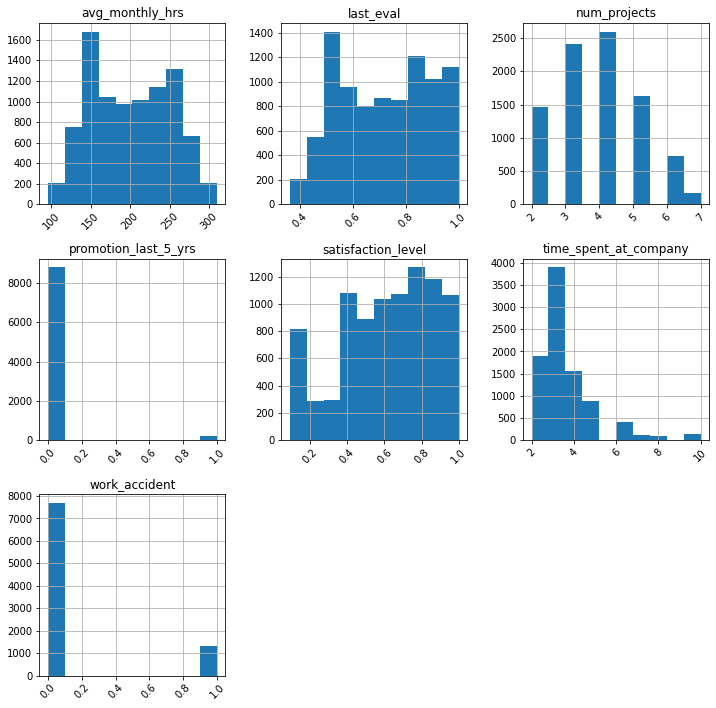

In [16]:
# histograms of numerical fields
# quit - our dependent variable is binary
# promotion in the last 5 years and work accident are also binary
df_train.hist(figsize=(12,12), xrot=45)
plt.show()

<h4>Observations</h4>
<ul>
    <li>As we can see from the histograms, we have an imbalanced dataset (i.e., the classes are not represented equally) with regards to quitting.  So while this is great news for the company that most people kept their jobs, it is not so good for our machine learning models.</li>
    <li>It is also imbalanced with regards to being promoted in the past 5 years or to work accidents.</li>
</ul>

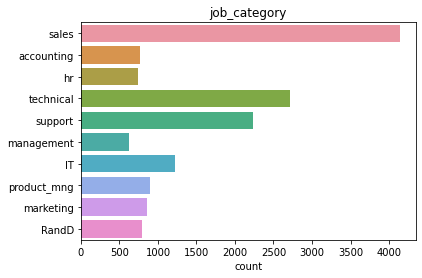

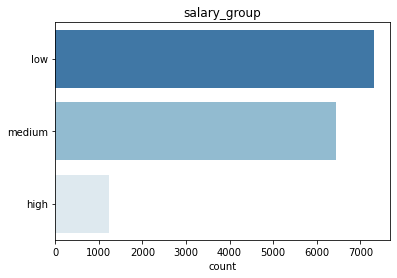

In [17]:
sns.set_palette(sns.color_palette("RdBu_r"))
for column in df_train.select_dtypes(include='object'):
    ax = sns.countplot(y=column, data=df)
    ax.set_title(column)
    ax.set_ylabel('')
    plt.show()

In [18]:
# grouping numeric features by each categorical feature
for column in df_train.select_dtypes(include='object'):
    display(df_train.groupby(column).mean())

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,promotion_last_5_yrs
job_category,,,,,,,
IT,0.623848,0.715619,3.794940,201.070573,3.476698,0.125166,0.002663
RandD,0.618030,0.718506,3.865801,197.872294,3.393939,0.162338,0.038961
accounting,0.589494,0.720401,3.869198,202.025316,3.561181,0.118143,0.016878
hr,0.604324,0.711530,3.638581,196.354767,3.321508,0.121951,0.024390
management,0.621410,0.725385,3.905128,202.507692,4.292308,0.174359,0.094872
marketing,0.613043,0.712628,3.658103,196.604743,3.604743,0.144269,0.045455
product_mng,0.618554,0.709696,3.814286,200.771429,3.467857,0.146429,0.000000
sales,0.611834,0.714164,3.794023,201.236672,3.577141,0.145396,0.025848
support,0.617404,0.723968,3.800450,200.699175,3.399100,0.162791,0.009752


,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,promotion_last_5_yrs
salary_group,,,,,,,
high,0.653342,0.706035,3.721245,199.227334,3.684709,0.148850,0.054127
low,0.598822,0.718328,3.800183,200.408312,3.429093,0.144097,0.009363
medium,0.617586,0.718073,3.819892,201.268745,3.569956,0.145323,0.028343


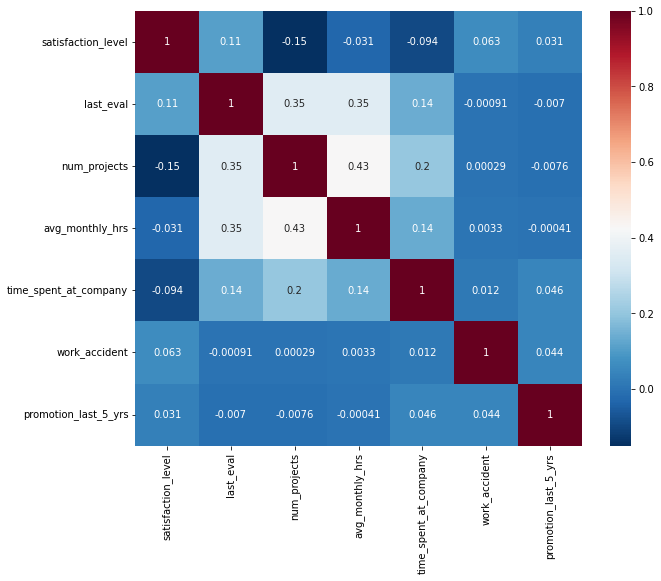

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train.corr(), cmap='RdBu_r', annot=True)
plt.show()

In [20]:
df_train.corr()

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,promotion_last_5_yrs
satisfaction_level,1.000000,0.109379,-0.150737,-0.031080,-0.093836,0.063017,0.030751
last_eval,0.109379,1.000000,0.354329,0.352775,0.140134,-0.000914,-0.007034
num_projects,-0.150737,0.354329,1.000000,0.427922,0.201158,0.000286,-0.007562
avg_monthly_hrs,-0.031080,0.352775,0.427922,1.000000,0.136616,0.003349,-0.000406
time_spent_at_company,-0.093836,0.140134,0.201158,0.136616,1.000000,0.011892,0.045883
work_accident,0.063017,-0.000914,0.000286,0.003349,0.011892,1.000000,0.044452
promotion_last_5_yrs,0.030751,-0.007034,-0.007562,-0.000406,0.045883,0.044452,1.000000


In [21]:
mutual_info_score(df_train['job_category'], y_train)

0.0029586989333794146

In [22]:
mutual_info_score(df_train['salary_group'], y_train)

0.01426984045365912

<h4>Observations</h4>
<ul>
    <li>It appears that none of our variables are highly correlated.</li>
    <li>We have some slight negative correlation between job satisfaction and the number of projects, average monthly hours, and time spent at the company.  This could be people feeling less happy with their jobs when they are overworked.</li>
    <li>We have some positive correlation between the number of projects and the last evaluation.  Same with the average monthly hours and the last evaluation, as well as, average monthly hours and the number of projects.  This could be managers giving positive evaluations to people getting more done.</li>
    <li>The mutal information score is a univariate metric measuring the relationship between two quanitities.  By knowing one quantity, how confident you would be about knowing the target quantity.  Our mutual information scores are pretty low, indicating the job category and the salary group are pretty independent of knowing whether someone will quit.</li>
</ul>

<h3>Feature Engineering</h3>
<ul>
    <li>Because we have so few variable in this data set, I am reluctant to throw any out.</li>
    <li>We could do either a forward or backward stepwise regression to see which features should be included/eliminated to generate the best regression model.</li>
    <li>Many machine learning algorithms are not able to handle imbalanced datasets.  The accuracy score could be misleading.  We can either use a different metric (as mentioned earlier, we will use roc_auc_score instead of accuracy), undersample the majority class, or oversample the minority class.</li>
    <li>Based on the resampling rules of thumb from Dr. Jason Brownlee, <a href="https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/">we should consider over sampling when you do not have a lot of data (tens of thousands of records or less)</a>. I will try oversampling the underrepresented class (people quitting) using SMOTE.</li>
</ul>   

<h3>Naive Bayes Example Showing the Difference of Using an Imbalanced Dataset and Using SMOTE to Oversample the Minority Class</h3>

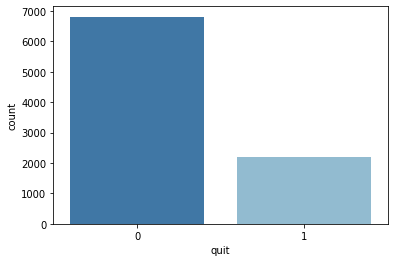

In [23]:
sns.countplot(x=y_train);

In [24]:
# summarize class distribution
print("Before oversampling training data: ", Counter(y_train))
SMOTE = SMOTE()
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)
print("After oversampling training data: ", Counter(y_train_SMOTE))

Before oversampling training data:  Counter({0: 6810, 1: 2189})
After oversampling training data:  Counter({0: 6810, 1: 6810})


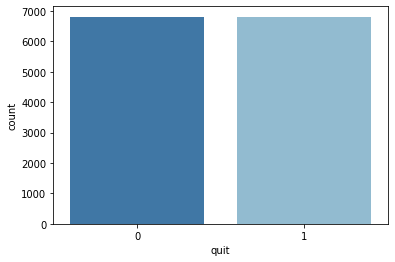

In [25]:
sns.countplot(x=y_train_SMOTE);

<h3>Naive Bayes on the Imbalanced Dataset</h3>

In [26]:
nb_model =  GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred=nb_model.predict(X_val)

In [27]:
pd.DataFrame(confusion_matrix(y_val, nb_pred), 
             columns=['Predicted Not Quitting','Predicted Quitting'], 
             index=['True Not Quitting', 'True Quitting'])

,Predicted Not Quitting,Predicted Quitting
True Not Quitting,1447,877
True Quitting,104,572


In [28]:
nb_imbal_scores  = pd.DataFrame(data = [['Naive Bayes Imbalanced Data',
                                  accuracy_score(y_val, nb_pred), 
                                  balanced_accuracy_score(y_val, nb_pred), 
                                  precision_score(y_val, nb_pred),
                                  recall_score(y_val, nb_pred), 
                                  f1_score(y_val, nb_pred), 
                                  roc_auc_score(y_val, nb_pred)]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
nb_imbal_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Naive Bayes Imbalanced Data,0.673,0.734394,0.394755,0.846154,0.538353,0.734394


Balanced Accuracy = (Sensitivity + Specificity)

Balanced Accuracy gives the same weight to both the majority and the minority classes.

<h3>Naive Bayes on the Balanced Dataset</h3>

In [29]:
nb_model2 =  GaussianNB()
nb_model2.fit(X_train_SMOTE, y_train_SMOTE)
nb_pred_bal=nb_model2.predict(X_val)

In [30]:
pd.DataFrame(confusion_matrix(y_val, nb_pred_bal), 
             columns=['Predicted Not Quitting','Predicted Quitting'], 
             index=['True Not Quitting', 'True Quitting'])

,Predicted Not Quitting,Predicted Quitting
True Not Quitting,929,1395
True Quitting,76,600


In [31]:
nb_bal_scores  = pd.DataFrame(data = [['Naive Bayes SMOTE',
                                accuracy_score(y_val, nb_pred_bal), 
                                balanced_accuracy_score(y_val, nb_pred_bal), 
                                precision_score(y_val, nb_pred_bal),
                                recall_score(y_val, nb_pred_bal), 
                                f1_score(y_val, nb_pred_bal), 
                                roc_auc_score(y_val, nb_pred_bal)]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
nb_bal_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Naive Bayes SMOTE,0.509667,0.643658,0.300752,0.887574,0.44927,0.643658


<h3>Observations</h3>
As you can see, the accuracy score is skewed higher when we do not balance the dataset.

<h3><a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">Logistic Regression</a></h3>

In [32]:
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [33]:
print('Logistic Regression intercept: {0}'.format(lr_model.intercept_[0]))

Logistic Regression intercept: -0.3374678062452393


In [34]:
print('Logistic Regression coefficients:')
print(lr_model.coef_[0].round(3))

Logistic Regression coefficients:
[ 0.005 -0.143 -0.564  0.009  0.267 -0.339  0.084  0.059  0.067  0.048
  0.174  0.56  -0.302 -0.937 -1.223  0.705  0.181 -4.207  0.259 -1.52 ]


In [35]:
lr_pred = lr_model.predict_proba(X_val)[:, 1]
lr_quit_decision = (lr_pred >= 0.5)
(y_val == lr_quit_decision).mean()

0.787

In [36]:
df_lr_pred = pd.DataFrame()
df_lr_pred['probability'] = lr_pred
df_lr_pred['prediction'] = lr_quit_decision.astype(int)
df_lr_pred['actual'] = y_val
df_lr_pred['correct'] = df_lr_pred.prediction == df_lr_pred.actual
df_lr_pred.head()

,probability,prediction,actual,correct
0,0.302378,0,0,True
1,0.068868,0,0,True
2,0.061906,0,0,True
3,0.434554,0,1,False
4,0.363078,0,1,False


In [37]:
lr_scores  = pd.DataFrame(data = [['Logistic Regression',
                            accuracy_score(y_val, df_lr_pred['prediction']),
                            balanced_accuracy_score(y_val, df_lr_pred['prediction']), 
                            precision_score(y_val, df_lr_pred['prediction']),
                            recall_score(y_val, df_lr_pred['prediction']), 
                            f1_score(y_val, df_lr_pred['prediction']), 
                            roc_auc_score(y_val, df_lr_pred['prediction'])]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
lr_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Logistic Regression,0.787,0.627022,0.544365,0.335799,0.415371,0.627022


<h3><a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">Decision Trees</a></h3>

We will tune the decision trees a few parameters at a time.

In [38]:
dt_scores = []

for depth in [4, 5, 6]:
    for s in [1, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        dt_scores.append((depth, s, auc))

In [39]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_dt_scores = pd.DataFrame(dt_scores, columns=columns)

In [40]:
df_dt_scores.sort_values('auc', ascending=False).head(10)

,max_depth,min_samples_leaf,auc
18,6,100,0.975525
14,6,1,0.974925
16,6,15,0.973960
15,6,10,0.973609
11,5,100,0.972772
19,6,200,0.971611
17,6,20,0.971465
4,4,100,0.971034
8,5,10,0.970684
12,5,200,0.970050


In [41]:
# this fails due to duplicates
#df_dt_scores_pivot = df_dt_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
#df_dt_scores_pivot.round(3)
#sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

Eye-balling to select the best Decision Tree model tuned on max_depth and min_samples_leaf

In [42]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)

Here we can see how our Decision Tree splits each node.

In [43]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- satisfaction_level <= 0.47
|   |--- num_projects <= 2.50
|   |   |--- avg_monthly_hrs <= 159.50
|   |   |   |--- satisfaction_level <= 0.38
|   |   |   |   |--- avg_monthly_hrs <= 141.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- avg_monthly_hrs >  141.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- satisfaction_level >  0.38
|   |   |   |   |--- avg_monthly_hrs <= 130.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- avg_monthly_hrs >  130.50
|   |   |   |   |   |--- last_eval <= 0.55
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- last_eval >  0.55
|   |   |   |   |   |   |--- class: 1
|   |   |--- avg_monthly_hrs >  159.50
|   |   |   |--- class: 0
|   |--- num_projects >  2.50
|   |   |--- satisfaction_level <= 0.11
|   |   |   |--- class: 1
|   |   |--- satisfaction_level >  0.11
|   |   |   |--- avg_monthly_hrs <= 262.50
|   |   |   |   |--- num_projects <= 5.50
|   |   |   |   |   |--- time_spent_at_company <= 4.50
|   |   |   |   | 

In [44]:
dt_pred = dt.predict(X_val)
dt_scores  = pd.DataFrame(data = [['Decision Tree',
                            accuracy_score(y_val, dt_pred),
                            balanced_accuracy_score(y_val, dt_pred), 
                            precision_score(y_val, dt_pred),
                            recall_score(y_val, dt_pred), 
                            f1_score(y_val, dt_pred), 
                            roc_auc_score(y_val, dt_pred)]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
dt_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Decision Tree,0.960333,0.934011,0.934477,0.886095,0.909643,0.934011


<h3>Decision Tree Evaluated on Imbalanced Dataset using RepeatedStratifiedKFold Cross Validation</h3>

We use cross validation to see how the model performs on unknown data. Basically, we split up our training data to use a subset and evaluate using the completmentary subset of data.  For instance, we may split it into 5 folds.  Each time training the data on 4/5ths of the training data and holding out 1/5 of the data for evaluation. We repeat this so that each of the folds is used as the test set.  Then we average the accuracy of the 5 folds.

<img src="images/kfold-validation-hitesh-gupta.jpg" alt="KFold Validation" style="width: 600px;"/>

Since most of the people in our dataset do not quit, we use Stratified K-fold Cross Validation so that each fold is a good representation of the complete dataset.

<img src="images/stratified-kfold-cv-image-by-hitesh-gupta.jpg">

<i>Images courtesy <a href="https://dockship.io/articles/6045b9c1c2c7fa59d94ed69a/a-gentle-introduction-to-cross-validation">Hitesh Gupta</a></i>

In [45]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(dt, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.976


<h3><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">Random Forest</a></h3>

Again we will tune the parameters a few at a time.

In [46]:
rf_scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        rf_scores.append((d, n, auc))

In [47]:
columns = ['max_depth', 'n_estimators', 'auc']
df_rf_scores = pd.DataFrame(rf_scores, columns=columns)

In [48]:
df_rf_scores.sort_values('auc', ascending=False).head(10)

,max_depth,n_estimators,auc
42,15,30,0.987987
41,15,20,0.987849
55,15,160,0.987765
56,15,170,0.987677
57,15,180,0.987647
59,15,200,0.987624
58,15,190,0.987501
54,15,150,0.987433
43,15,40,0.987366
52,15,130,0.987192


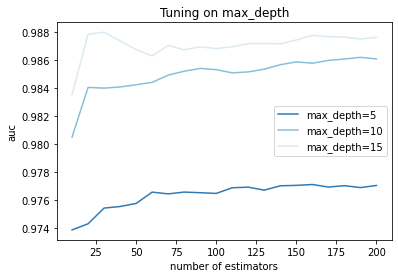

In [49]:
for d in [5, 10, 15]:
    df_subset = df_rf_scores[df_rf_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend();
plt.title('Tuning on max_depth');
plt.xlabel('number of estimators');
plt.ylabel('auc');

<h3>Observations</h3>
When tuning by max_depth and n_estimators, it looks like max_depth = 15 and the n_estimators at 30 give the best AUC.

In [50]:
max_depth=15

In [51]:
rf_scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        rf_scores.append((s, n, auc))

In [52]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_rf_scores = pd.DataFrame(rf_scores, columns=columns)

In [53]:
df_rf_scores.sort_values('auc', ascending=False).head(10)

,min_samples_leaf,n_estimators,auc
2,1,30,0.987987
1,1,20,0.987849
15,1,160,0.987765
22,3,30,0.987679
16,1,170,0.987677
17,1,180,0.987647
19,1,200,0.987624
49,5,100,0.987571
48,5,90,0.987555
51,5,120,0.987501


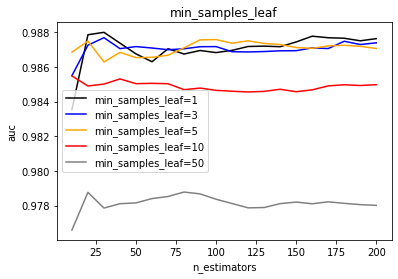

In [54]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_rf_scores[df_rf_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend();
plt.title('min_samples_leaf');
plt.xlabel('n_estimators');
plt.ylabel('auc');

<h3>Observations</h3>
When tuning by min_samples_leaf and n_estimators, it looks like min_samples_leaf = 1 and the n_estimators at 30 give the best AUC.

In [55]:
min_samples_leaf = 1

In [56]:
rf_scores = []

for b in [True, False]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    bootstrap=b,
                                    random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        rf_scores.append((b, n, auc))

In [57]:
columns = ['bootstrap', 'n_estimators', 'auc']
df_rf_scores = pd.DataFrame(rf_scores, columns=columns)

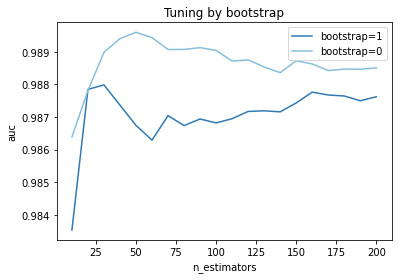

In [58]:
for b in [True, False]:
    df_subset = df_rf_scores[df_rf_scores.bootstrap == b]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='bootstrap=%d' % b)

plt.legend();
plt.title('Tuning by bootstrap');
plt.xlabel('n_estimators');
plt.ylabel('auc');

In [59]:
n_estimators=30
bootstrap=False

<h3>Based on our tuning, we will use 30 estimators, no bootstrapping, max depth of 15, min sample leafs of 1</h3>

In [60]:
rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            bootstrap=bootstrap,
                            random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict_proba(X_val)[:, 1]
rf_quit_decision = (rf_pred >= 0.5)
(y_val == rf_quit_decision).mean()

0.985

In [61]:
df_rf_pred = pd.DataFrame()
df_rf_pred['probability'] = rf_pred
df_rf_pred['prediction'] = rf_quit_decision.astype(int)
df_rf_pred['actual'] = y_val
df_rf_pred['correct'] = df_rf_pred.prediction == df_rf_pred.actual
df_rf_pred.head()

,probability,prediction,actual,correct
0,0.044975,0,0,True
1,0.003337,0,0,True
2,0.007407,0,0,True
3,0.997930,1,1,True
4,0.929088,1,1,True


In [62]:
rf_scores  = pd.DataFrame(data = [['Random Forest',
                            accuracy_score(y_val, df_rf_pred['prediction']),
                            balanced_accuracy_score(y_val, df_rf_pred['prediction']), 
                            precision_score(y_val, df_rf_pred['prediction']),
                            recall_score(y_val, df_rf_pred['prediction']), 
                            f1_score(y_val, df_rf_pred['prediction']), 
                            roc_auc_score(y_val, df_rf_pred['prediction'])]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
rf_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest,0.985,0.970387,0.989147,0.943787,0.965935,0.970387


<h3><a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html">Support Vector Machines</a></h3>

In [63]:
clf = svm.SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)
svm_pred = clf.predict(X_val)

In [64]:
svm_scores = pd.DataFrame(data= [['SVM',
                                  accuracy_score(y_val, svm_pred),
                                  balanced_accuracy_score(y_val, svm_pred),
                                  precision_score(y_val, svm_pred),
                                  recall_score(y_val, svm_pred),
                                  f1_score(y_val, svm_pred),
                                  roc_auc_score(y_val, svm_pred)]],
                          columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
svm_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,SVM,0.775667,0.590335,0.504425,0.252959,0.336946,0.590335


<h3><a href="https://xgboost.readthedocs.io/en/latest/python/index.html">XGBoost</a></h3>

In [65]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [66]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

[12:54:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
xgb_pred = model.predict(dval)

In [68]:
xgb_pred

array([0.1182857 , 0.02548627, 0.03275238, ..., 0.03192684, 0.9432536 ,
       0.9684244 ], dtype=float32)

In [69]:
roc_auc_score(y_val, y_pred)

0.9885087688030226

In [70]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [71]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [72]:
s = output.stdout

In [73]:
print(s[:200])

[0]	train-auc:0.97753	val-auc:0.96909
[5]	train-auc:0.98906	val-auc:0.98148
[10]	train-auc:0.99416	val-auc:0.98519
[15]	train-auc:0.99609	val-auc:0.98815
[20]	train-auc:0.99719	val-auc:0.98918
[25]	tr


In [74]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [75]:
df_xgb_score = parse_xgb_output(output)

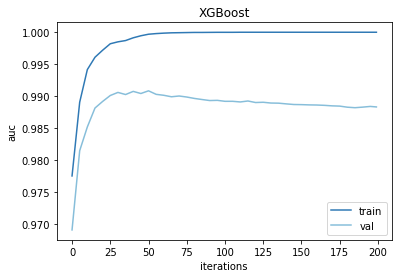

In [76]:
plt.plot(df_xgb_score.num_iter, df_xgb_score.train_auc, label='train')
plt.plot(df_xgb_score.num_iter, df_xgb_score.val_auc, label='val')
plt.legend();
plt.title('XGBoost');
plt.xlabel('iterations');
plt.ylabel('auc');

In [77]:
df_xgb_score.sort_values('val_auc', ascending=False).head(10)

,num_iter,train_auc,val_auc
10,50,0.99969,0.99084
8,40,0.99913,0.99075
6,30,0.99850,0.99059
9,45,0.99945,0.99042
11,55,0.99979,0.99029
7,35,0.99870,0.99026
12,60,0.99986,0.99014
5,25,0.99820,0.99011
14,70,0.99993,0.99003
13,65,0.99991,0.98991


<h3>XGBoost Parameter Tuning Using GridSearchCV</h3>

GridSearchCV is a more automated way to try testing a lot of parameter choices for tuning.  We should run this on the full train dataset since scikit learn will be handling the cross validation internally and uses just train and test.  This will take a while to run.

<h3>Train on the full training and validation data sets</h3>

In [78]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train['quit']
del df_full_train['quit']

In [79]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [80]:
param_grid = {
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.3, 0.1, 0.01, 0.05],  
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    "seed": [42],
}

In [81]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")
_ = grid_cv.fit(X_full_train, y_full_train)

[13:02:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [82]:
grid_cv.best_score_

0.9932698180958456

In [83]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'reg_lambda': 0,
 'scale_pos_weight': 3,
 'seed': 42,
 'subsample': 0.8}

We will use the best parameters generated by our Grid search for our XGBoost model

In [84]:
xgb_params = {'colsample_bytree': 0.5,
              'gamma': 1,
              'learning_rate': 0.1,
              'objective': 'binary:logistic',
              'max_depth': 6,
              'reg_lambda': 0,
              'scale_pos_weight': 3,
              'seed': 42,
              'subsample': 0.8,
              'nthread': 8,
              'verbosity': 1}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=10)
xgb_pred = xgb_model.predict(dval)

[13:02:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [85]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic", 
                           colsample_bytree=0.5,
                           gamma=0,
                           learning_rate=0.1,
                           max_depth=6,
                           reg_lambda=0,
                           scale_pos_weight=3,
                           subsample=0.8,
                           seed=42)
xgb_cl.fit(X_train, y_train)
xbg_pred = model.predict(dval)
xgb_quit_decision = (xgb_pred >= 0.5)

[13:02:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [86]:
df_xgb_pred = pd.DataFrame()
df_xgb_pred['probability'] = xgb_pred
df_xgb_pred['prediction'] = xgb_quit_decision.astype(int)
df_xgb_pred['actual'] = y_val
df_xgb_pred['correct'] = df_xgb_pred.prediction == df_xgb_pred.actual
df_xgb_pred.head()

,probability,prediction,actual,correct
0,0.573351,1,0,False
1,0.200619,0,0,True
2,0.390817,0,0,True
3,0.807441,1,1,True
4,0.797907,1,1,True


In [87]:
xgb_scores  = pd.DataFrame(data = [['XGBoost',
                            accuracy_score(y_val, df_xgb_pred['prediction']),
                            balanced_accuracy_score(y_val, df_xgb_pred['prediction']), 
                            precision_score(y_val, df_xgb_pred['prediction']),
                            recall_score(y_val, df_xgb_pred['prediction']), 
                            f1_score(y_val, df_xgb_pred['prediction']), 
                            roc_auc_score(y_val, df_xgb_pred['prediction'])]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
xgb_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,XGBoost,0.969333,0.948737,0.950617,0.911243,0.930514,0.948737


<h3>Selecting a Model</h3>

In [88]:
model_scores = pd.concat([nb_imbal_scores, nb_bal_scores, lr_scores, rf_scores, svm_scores, xgb_scores])
model_scores.sort_values('ROC AUC', ascending=False)

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest,0.985000,0.970387,0.989147,0.943787,0.965935,0.970387
0,XGBoost,0.969333,0.948737,0.950617,0.911243,0.930514,0.948737
0,Naive Bayes Imbalanced Data,0.673000,0.734394,0.394755,0.846154,0.538353,0.734394
0,Naive Bayes SMOTE,0.509667,0.643658,0.300752,0.887574,0.449270,0.643658
0,Logistic Regression,0.787000,0.627022,0.544365,0.335799,0.415371,0.627022
0,SVM,0.775667,0.590335,0.504425,0.252959,0.336946,0.590335


Based on the ROC AUC metric, it appears the both Random Forest and XGBoost perform very well on our validation data.

<h3>Train in the full train dataset (training and validation) and evaluate on the test data</h3>

<h3>XGBoost</h3>

In [89]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

In [90]:
xgb_params = {'colsample_bytree': 0.5,
              'gamma': 1,
              'learning_rate': 0.1,
              'objective': 'binary:logistic',
              'max_depth': 6,
              'reg_lambda': 0,
              'scale_pos_weight': 3,
              'seed': 42,
              'subsample': 0.8,
              'nthread': 8,
              'verbosity': 1}

xgb_model = xgb.train(xgb_params, dfulltrain, num_boost_round=10)
xgb_pred = xgb_model.predict(dtest)
xgb_quit_decision = (xgb_pred >= 0.5)

[13:02:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [91]:
xgb_f_scores  = pd.DataFrame(data = [['XGBoost (Full Train)',
                            accuracy_score(y_val, xgb_quit_decision.astype(int)),
                            balanced_accuracy_score(y_val, xgb_quit_decision.astype(int)), 
                            precision_score(y_val, xgb_quit_decision.astype(int)),
                            recall_score(y_val, xgb_quit_decision.astype(int)), 
                            f1_score(y_val, xgb_quit_decision.astype(int)), 
                            roc_auc_score(y_val, xgb_quit_decision.astype(int))]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
xgb_f_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,XGBoost (Full Train),0.654,0.511806,0.242898,0.252959,0.247826,0.511806


In [92]:
roc_auc_score(y_val, xgb_pred)

0.5316115476275347

<h3>Random Forest</h3>

In [93]:
# random forest parameters
max_depth=15
min_samples_leaf = 1
n_estimators=30
bootstrap=False
random_state=42

In [94]:
rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            bootstrap=bootstrap,
                            random_state=random_state)
rf.fit(X_full_train, y_full_train)
rf_pred = rf.predict_proba(X_test)[:, 1]
rf_quit_decision = (rf_pred >= 0.5)

In [95]:
rf_f_scores  = pd.DataFrame(data = [['Random Forest (Full Train)',
                            accuracy_score(y_val, rf_quit_decision.astype(int)),
                            balanced_accuracy_score(y_val, rf_quit_decision.astype(int)), 
                            precision_score(y_val, rf_quit_decision.astype(int)),
                            recall_score(y_val, rf_quit_decision.astype(int)), 
                            f1_score(y_val, rf_quit_decision.astype(int)), 
                            roc_auc_score(y_val, rf_quit_decision.astype(int))]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
rf_f_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest (Full Train),0.660333,0.516943,0.251089,0.255917,0.25348,0.516943


In [96]:
final_model_scores = pd.concat([rf_f_scores, xgb_f_scores])
final_model_scores.sort_values('ROC AUC', ascending=False)

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest (Full Train),0.660333,0.516943,0.251089,0.255917,0.253480,0.516943
0,XGBoost (Full Train),0.654000,0.511806,0.242898,0.252959,0.247826,0.511806


<h3>Observations</h3>
Overall, neither model performed well on the test dataset. You want the ROC AUC scores to be > .5. If there were more time, I would experiment more.
Since the Random Forest model had slightly higher scores for everything across the board, so we will choose it for deployment.

<h3>Export the model for deployment</h3>

In [97]:
def train(df_train, y_train, n_estimators, max_depth, min_samples_lead, bootstrap, random_state):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      bootstrap=bootstrap,
                                      random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    return dv, model

In [98]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [99]:
output_file = 'rf_model.bin'

with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, rf), f_out)

<a id='reference'></a>
# Reference

[HR Retention Prediction dataset by Vincent Tatan](https://github.com/VincentTatan/PythonAnalytics/blob/master/Youtube/dataset/HR_comma_sep.csv) *last updated on github 1/18/17*

[The geography of the Great Resignation: First-time data shows where Americans are quitting the most](https://www.washingtonpost.com/business/2021/10/22/states-labor-quitting-turnvoer-jolts/)
by Alyssa Fowers and Eli Rosenberg, *published: 10/22/21, accessed: 10/23/21*

[The Great Resignation: Why People Are Leaving Their Jobs In Growing Numbers](https://www.npr.org/2021/10/22/1048332481/the-great-resignation-why-people-are-leaving-their-jobs-in-growing-numbers)
*published: 10/22/21, accessed: 10/23/21*

[Why are so many Americans quitting their jobs?](https://www.npr.org/sections/money/2021/10/19/1047032996/why-are-so-many-americans-quitting-their-jobs)
by Greg Rosalsky, *published: 10/19/21, accessed: 10/23/21*

[The ‘Great Resignation’ Is A Workers’ Revolution: Here’s What Real Leaders Must Do Right Now](https://www.forbes.com/sites/jackkelly/2021/10/08/the-great-resignation-is-a-workers-revolution-heres-what-real-leaders-must-do-right-now/?sh=5c2b453f514f) by Jack Kelly, *published: 10/8/21; accessed: 10/23/21*

[The Great Resignation Update: Limeade Employee Care Report](https://www.limeade.com/resources/resource-center/limeade-employee-care-report-the-great-resignation-update/) *accessed: 10/23/21*

[The Great Resignation Is Accelerating: A lasting effect of this pandemic will be a revolution in worker expectations.](https://www.theatlantic.com/ideas/archive/2021/10/great-resignation-accelerating/620382/) by Derek Thompson, *published: 10/15/21, accessed: 10/23/21*

[The Great Resignation is no joke](https://fortune.com/2021/10/21/the-great-resignation-is-no-joke/) by Lance Lambert, *published: 10/21/21, accessed: 10/23/21*

[US Bureau of Labor Statistics: Table 4. Quits levels and rates by industry and region, seasonally adjusted](https://www.bls.gov/news.release/jolts.t04.htm) *published: 10/12/21, accessed: 10/23/21*

[‘Micromanaged and disrespected’: Top reasons workers are quitting their jobs in ‘The Great Resignation’
Health concerns, increased workloads, unrealistic manager expectations are pushing many to the breaking point, readers tell me. And those who can afford to quit or take early retirement are leaving. ](https://www.washingtonpost.com/business/2021/10/07/top-reasons-great-resignation-workers-quitting/)
by Karla L. Miller, *published: 10/7/21, accessed: 10/23/21*

[During the ‘Great Resignation,’ workers refuse to accept the unacceptable
People who are used to tolerating bad work situations are increasingly leaving their jobs and demanding better working conditions](https://www.washingtonpost.com/business/2021/09/30/during-great-resignation-workers-refuse-accept-unacceptable/)by Karla L. Miller, *published: 9/30/21, accessed: 10/23/21*

[Who Is Driving the Great Resignation?](https://hbr.org/2021/09/who-is-driving-the-great-resignation)
by Ian Cook
*published: 9/15/21, accessed: 10/23/21*

[As The Pandemic Recedes, Millions Of Workers Are Saying 'I Quit'](https://www.npr.org/2021/06/24/1007914455/as-the-pandemic-recedes-millions-of-workers-are-saying-i-quit)
by Andrea Hsu, *published: 6/24/21, accessed: 10/23/21*

[Wikipedia: The Great Resignation](https://en.wikipedia.org/wiki/Great_Resignation)
*accessed: 10/23/21*